In [1]:
!pip install roboticstoolbox-python --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 MB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.8/190.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 22.9 MB/s eta

In [21]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import roboticstoolbox as rtb

# Модель робота
robot = lambda _l1, _l2: rtb.ET2.R() * rtb.ET2.tx(_l1) * rtb.ET2.R() * rtb.ET2.tx(_l2)

# Функция для генерации данных
def generate_data(num_of_samples_,
                  robot_,
                  qlims_,
                  df_,
                  drop_ = True):
    if drop_:
        df_.drop(df_.index)  # Очищаем DataFrame
    for _ in range(num_of_samples_):
        _q = [np.random.uniform(low=np.deg2rad(_l[0]),
                                high=np.deg2rad(_l[1])) for _l in qlims_]
        _p = robot_.fkine(q=_q).t  # Вычисление положения
        # Составляем новую строку для df_
        _row = pd.DataFrame()
        _row[['q' + str(_i + 1) for _i in range(len(_q))]] = [_q]
        _row[['x' + str(_i + 1) for _i in range(len(_p))]] = [_p]
        # Добавляем строку _row в _df
        df_ = pd.concat([df_, _row], ignore_index=True)
    return df_

# Инициализация DataFrame с колонками для углов и координат
df = pd.DataFrame(columns=['q1', 'q2'] + ['x1', 'x2'])
print(df)

# Генерация данных
df = generate_data(num_of_samples_=5000,
                  robot_=robot(30, 40),
                  qlims_=[(0, 10), (0, 10)],
                  df_=df)

# Сохранение данных в CSV файл
df.to_csv('generated_data.csv', index=False)


Empty DataFrame
Columns: [q1, q2, x1, x2]
Index: []


<ipython-input-21-0b30e1b8ea01>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ = pd.concat([df_, _row], ignore_index=True)


In [35]:

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

# Загрузка данных из CSV
df = pd.read_csv('generated_data.csv')

# Определение столбцов
input_cols = ['x1', 'x2']
target_cols = ['q1', 'q2']

# Предобработка данных
p_train, p_test, q_train, q_test = train_test_split(
    df[input_cols],
    df[target_cols],
    test_size=0.33,
    random_state=42
)

# Масштабирование данных
std_scaler = StandardScaler()
rbst_scaler = RobustScaler()

p_train_scaled = rbst_scaler.fit_transform(p_train)
q_train_scaled = std_scaler.fit_transform(q_train)

# Построение модели
model = tf.keras.models.Sequential()

# Добавление первого слоя с большим количеством нейронов
model.add(tf.keras.layers.Dense(units=64, input_shape=(len(input_cols), ), activation='relu'))

# Добавление скрытого слоя с использованием Dropout и L2-регуляризации
model.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.3))

# Добавление второго скрытого слоя с увеличением нейронов
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Выходной слой
model.add(tf.keras.layers.Dense(units=len(target_cols)))

model.summary()

# Компиляция модели с новой функцией потерь и оптимизатором
model.compile(optimizer='adam',
              loss='mean_absolute_error',  # Использование MAE для более стабильных результатов
              metrics=['mse', 'mae', 'mape'])

# Контроллер чекпоинтов для сохранения модели
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'model_checkpoint.keras',  # Путь для сохранения модели
    save_weights_only=False,  # Сохранять не только веса, но и структуру модели
    save_best_only=True,  # Сохранять только лучшие веса
    verbose=1  # Печать информации о сохранении
)

# Контроллер для ранней остановки
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Мониторинг валидационной потери
    patience=10,  # Количество эпох без улучшений
    verbose=1,  # Печать сообщений о прекращении обучения
    restore_best_weights=True  # Восстановление лучших весов модели
)

# Обучение модели с контроллерами
history = model.fit(
    p_train_scaled,
    q_train_scaled,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    verbose=1,
    callbacks=[checkpoint_callback, early_stop_callback]  # Добавление контроллеров
)

# Сохранение истории обучения в CSV файл
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,498 (25.38 KB)

 Trainable params: 6,498 (25.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
334/335 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9760 - mae: 0.6398 - mape: 181.0948 - mse: 0.6027
Epoch 1: val_loss improved from inf to 0.47224, saving model to model_checkpoint.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.9747 - mae: 0.6393 - mape: 181.0236 - mse: 0.6020 - val_loss: 0.4722 - val_mae: 0.4033 - val_mape: 154.6495 - val_mse: 0.2605
Epoch 2/100
334/335 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4209 - mae: 0.3521 - mape: 118.9616 - mse: 0.2062
Epoch 2: val_loss improved from 0.47224 to 0.23168, saving model to model_checkpoint.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4206 - mae: 0.3518 - mape: 118.9044 - mse: 0.2059 - val_loss: 0.2317 - val_mae: 0.1717 - val_mape: 102.5649 - val_mse: 0.0496
Epoch 3/100
319/335 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3026 - mae: 0.2457 - mape: 94.3484 - mse: 0.1023
Epoch 3: val_loss improved from 0.23168 to 0.22251, saving model to model_checkpoint.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/ste

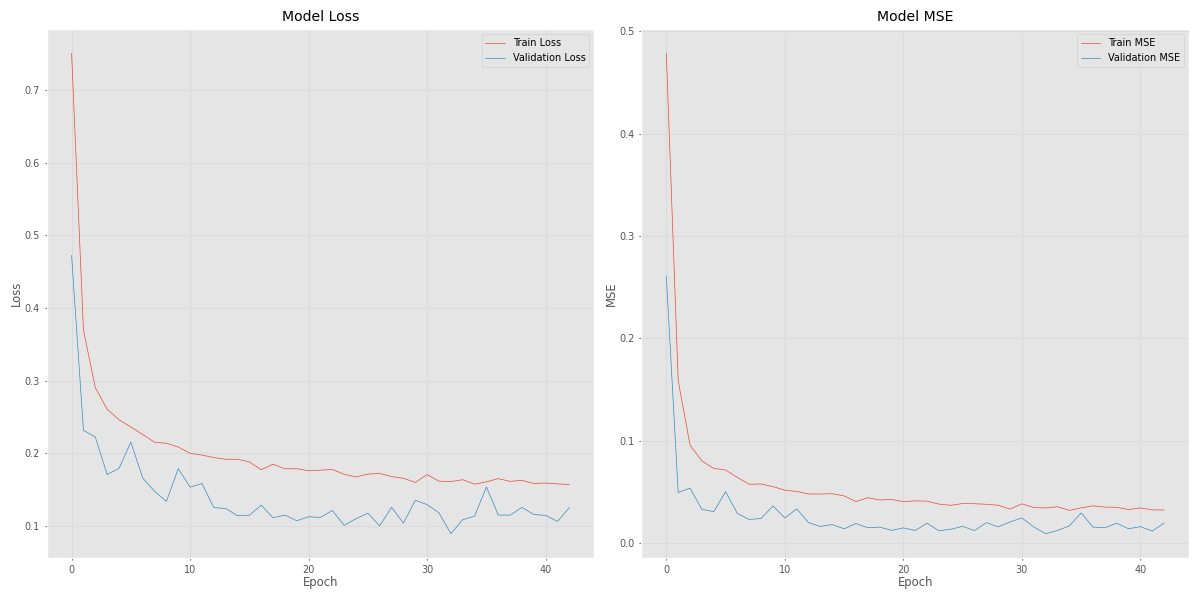

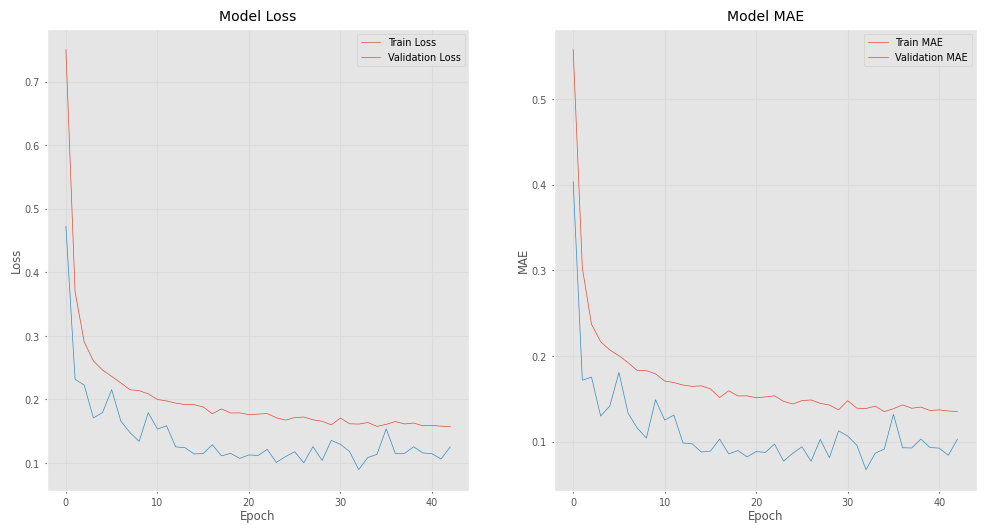

Final Training Loss: 0.1571
Final Validation Loss: 0.1253
Final Training MAE: 0.1352
Final Validation MAE: 0.1030
Final Training MSE: 0.0325
Final Validation MSE: 0.0198
Final Training MAPE: 54.1417
Final Validation MAPE: 59.4636


In [36]:
import matplotlib.pyplot as plt

# Загрузка сохраненной модели (последний лучший вариант)
best_model = tf.keras.models.load_model('model_checkpoint.keras')


# График потерь на обучении и валидации
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# График MSE на обучении и валидации
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
# Графики потерь и метрик (по аналогии с предыдущим кодом)
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# График метрик
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

# Итоговые значения после обучения
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_mae = history.history['mae'][-1]
final_val_mae = history.history['val_mae'][-1]
final_train_mse = history.history['mse'][-1]
final_val_mse = history.history['val_mse'][-1]
final_train_mape = history.history['mape'][-1]
final_val_mape = history.history['val_mape'][-1]

# Вывод итоговых значений
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training MAE: {final_train_mae:.4f}")
print(f"Final Validation MAE: {final_val_mae:.4f}")
print(f"Final Training MSE: {final_train_mse:.4f}")
print(f"Final Validation MSE: {final_val_mse:.4f}")
print(f"Final Training MAPE: {final_train_mape:.4f}")
print(f"Final Validation MAPE: {final_val_mape:.4f}")



**1. Показатели из первого набора:**
loss: 103.0578 - mae: 0.8307 - mape: 103.0578 - mse: 0.9300 - val_loss: 102.2891 - val_mae: 0.8148 - val_mape: 102.2891 - val_mse: 0.8916

**2. Показатели из второго набора (финальные):**
Final Training Loss: 0.1571
Final Validation Loss: 0.1253
Final Training MAE: 0.1352
Final Validation MAE: 0.1030
Final Training MSE: 0.0325
Final Validation MSE: 0.0198
Final Training MAPE: 54.1417
Final Validation MAPE: 59.4636

**Сравнение и анализ:**
Loss (потери):

Первый набор:
Потери на обучении (loss) — 103.0578,
потери на валидации (val_loss) — 102.2891.

Это очень высокие значения потерь, что может свидетельствовать о слабом обучении модели, высокой ошибке в предсказаниях и возможных проблемах с обобщением.

Второй набор:
Потери на обучении (loss) — 0.1571,
потери на валидации (val_loss) — 0.1253.
Это значительно более низкие значения потерь, что указывает на гораздо более точное обучение и хорошую способность модели к обобщению.

MAE (средняя абсолютная ошибка):

Первый набор:

 MAE на обучении — 0.8307, MAE на валидации — 0.8148. Эти значения говорят о том, что модель ошибается в среднем на 0.83 и 0.81 для обучающих и валидационных данных, что довольно высоко.
Второй набор: MAE на обучении — 0.1352, MAE на валидации — 0.1030. Значения MAE значительно ниже, что означает, что модель делает значительно меньшие ошибки и обучена намного лучше.
MSE (среднеквадратичная ошибка):

Первый набор:

MSE на обучении — 0.9300, MSE на валидации — 0.8916. Эти значения MSE говорят о том, что модель вносит значительные ошибки в предсказания.
Второй набор: MSE на обучении — 0.0325, MSE на валидации — 0.0198. Здесь MSE значительно снижены, что указывает на более высокое качество модели и меньшие ошибки.
MAPE (средняя абсолютная процентная ошибка):

Первый набор:

MAPE на обучении — 103.0578, MAPE на валидации — 102.2891. Эти значения указывают на очень высокую ошибку в процентах. Это говорит о том, что модель плохо справляется с точностью предсказаний.
Второй набор: MAPE на обучении — 54.1417, MAPE на валидации — 59.4636. Хотя MAPE всё ещё достаточно высок, значения гораздо ниже, чем в первом наборе, что свидетельствует о значительном улучшении модели.

**Основные выводы:**

Во втором наборе данных модель проделала значительную работу, достигнув более низких значений потерь, MAE, MSE и MAPE, что свидетельствует о гораздо лучшем обучении и способности к обобщению. Эти улучшения делают модель гораздо более точной и эффективной по сравнению с первым набором данных.
Первый набор данных показывает признаки плохого обучения, высокой ошибки и переобучения, что может быть связано с проблемами с гиперпараметрами, функцией потерь, архитектурой модели или недостаточным количеством данных.
Во втором наборе данные выглядят гораздо более оптимизированными, и модель достигла хороших результатов на обеих выборках (обучающей и валидационной).